## Ablation Study(제거 연구)
* 딥러닝 논문은 여러가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시한다.
* 이 때 제안한 방법들의 유효함을 증명하기 위해 해당 방법을 **제거**한 모델로 수행한 실험과 해당 방법을 **추가**한 모델로 수행한 실험의 결과를 비교한다.
* 즉 **Ablation study란 '아이디어를 제거해 봄으로써' 제안한 방법이 어떻게 성능이나 문제의 해결에 효과를 주는지 확인하는 실험**이다.

### ResNet논문에서 제시한 residual connection 애블레이션 연구
* ImageNet 검증 데이터셋에 대한 Top-1 error rate을 지표로 사용해 residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교했을 때 residual connection을 활용해 깊은 네트워크를 쌓았을 때 이를 통한 성능 향상을 얻을 수 있음을 확인할 수 있다.
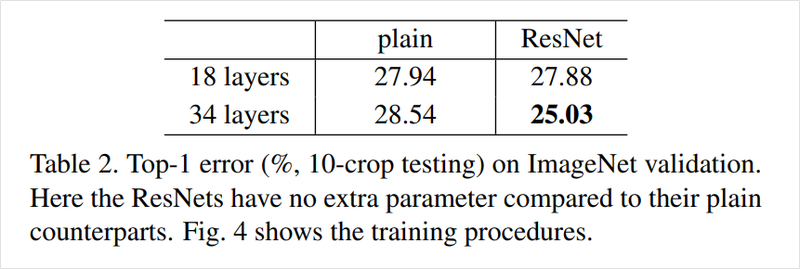

## 1. VGG-16과 VGG-19를 통한 예시
CIFAR-10에 대해 ResNet을 구현하는 것은 어려울 수도 있으므로 VGG를 예시로 구현한다.

### (1) CIFAR-10
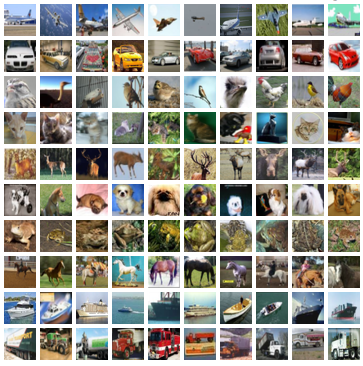
* 10개의 카테고리에 대한 총 6만장의 이미지 데이터셋
* 각 이미지는 32*32픽셀

```
$ pip install tensorflow-datasets
```

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 본다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar() # 이 주석을 풀면 데이터셋 다운로드 과정의 프로그레스바가 나타나지 않는다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 Feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### (2) Input Normalization
이미지 데이터를 입력할 때 각 픽셀의 최대값인 255로 정규화해주어 0과 1사이의 값이 되도록 Normalization해준다.

In [6]:
def normalize_and_resize_img(image,label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32,32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features['label'].num_classes

10

In [9]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

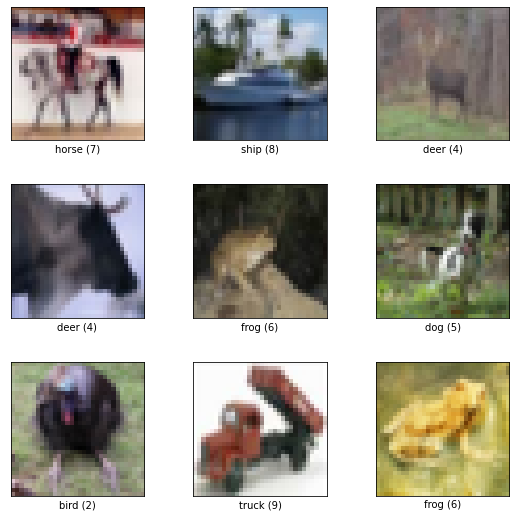

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

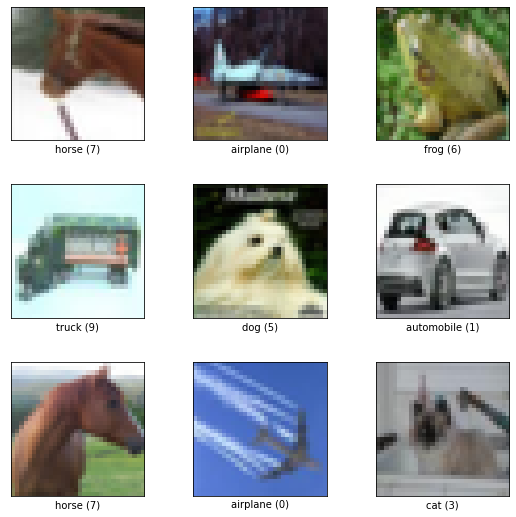

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

### (3) VGG-16과 VGG-19의 기본 블록 구성

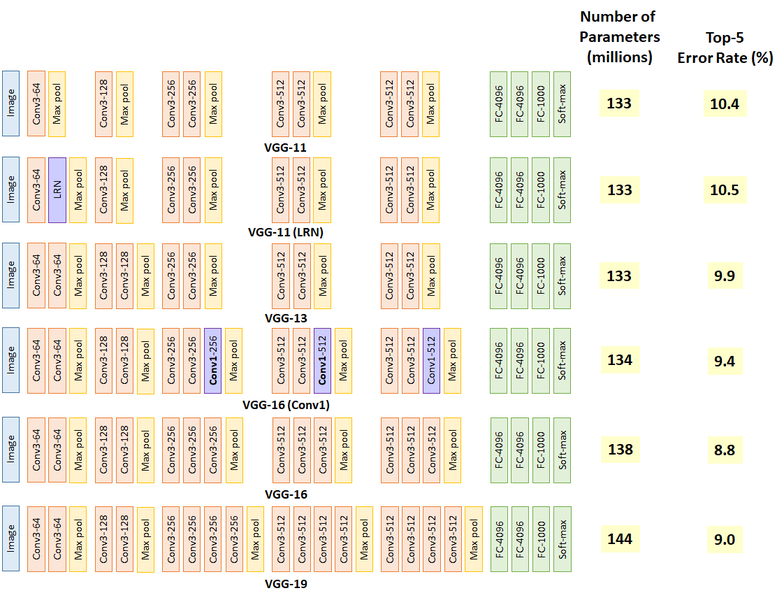

* VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한개로 이루어진다.
* CNN은 모두 커널의 크기가 3x3 라는 특징을 가지고 있다.
* 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다.
* 블록에 따라서 CNN 레이어의 개수 또한 달라진다.
* 블록의 마지막에는 항상 Max Pooling 레이어가 붙기 때문에 블록은 CNN 레이어 여러개와 Max Pooling 레이어 한 개로 이루어질 것이며, CNN의 레이어 수와 채널을 조절할 수 있어야 한다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                   num_cnn = 3,
                   channel=64,
                   block_num = 1,
                   ):
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation = 'relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
            )(x)
        
    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)
    
    return x

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3)) # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer) # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs = vgg_block_output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


#### VGG-16

In [18]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [19]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

#### VGG-19

In [20]:
vgg_19 = build_vgg(
    num_cnn_list = [2,2,4,4,4],
    channel_list = [64,128,256,512,512]
)

vgg_19.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## 2. VGG-16 vs VGG-19

위에서 준비한 데이터셋과 모델의 성능 비교를 위해 모델을 훈련하고 평가한다.

### (1) CIFAR-10 데이터셋 불러오기

In [21]:
BATCH_SIZE = 256
EPOCH = 20

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test,batch_size=BATCH_SIZE)

#### VGG-16 모델 생성 및 훈련

In [23]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01,clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 97s 379ms/step - loss: 2.2485 - accuracy: 0.1632 - val_loss: 2.0652 - val_accuracy: 0.2653
Epoch 2/20
195/195 [==============================] - 49s 252ms/step - loss: 2.0200 - accuracy: 0.2753 - val_loss: 1.9359 - val_accuracy: 0.3123
Epoch 3/20
195/195 [==============================] - 49s 253ms/step - loss: 1.8752 - accuracy: 0.3232 - val_loss: 1.7532 - val_accuracy: 0.3821
Epoch 4/20
195/195 [==============================] - 50s 256ms/step - loss: 1.7533 - accuracy: 0.3684 - val_loss: 1.6476 - val_accuracy: 0.4132
Epoch 5/20
195/195 [==============================] - 50s 256ms/step - loss: 1.6680 - accuracy: 0.4013 - val_loss: 1.6045 - val_accuracy: 0.4141
Epoch 6/20
195/195 [==============================] - 50s 257ms/step - loss: 1.6006 - accuracy: 0.4234 - val_loss: 1.5718 - val_accuracy: 0.4228
Epoch 7/20
195/195 [==============================] - 50s 257ms/step - loss: 1.5537 - accuracy: 0.4398 - val_loss: 1.5269 - val_ac

#### VGG-19 모델 생성 및 훈련

In [24]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 66s 307ms/step - loss: 2.2761 - accuracy: 0.1410 - val_loss: 2.1340 - val_accuracy: 0.2177
Epoch 2/20
195/195 [==============================] - 59s 305ms/step - loss: 2.0953 - accuracy: 0.2298 - val_loss: 1.9700 - val_accuracy: 0.2961
Epoch 3/20
195/195 [==============================] - 60s 305ms/step - loss: 1.9636 - accuracy: 0.2824 - val_loss: 1.8787 - val_accuracy: 0.3312
Epoch 4/20
195/195 [==============================] - 60s 306ms/step - loss: 1.8388 - accuracy: 0.3334 - val_loss: 1.7609 - val_accuracy: 0.3583
Epoch 5/20
195/195 [==============================] - 60s 307ms/step - loss: 1.7444 - accuracy: 0.3679 - val_loss: 1.7021 - val_accuracy: 0.3727
Epoch 6/20
195/195 [==============================] - 60s 306ms/step - loss: 1.6669 - accuracy: 0.3957 - val_loss: 1.5986 - val_accuracy: 0.4186
Epoch 7/20
195/195 [==============================] - 60s 307ms/step - loss: 1.6067 - accuracy: 0.4196 - val_loss: 1.5738 - val_ac

#### VGG-16과 VGG-19 Accuracy 비교

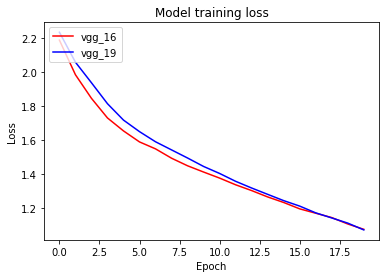

In [25]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

#### Validation Accuracy 비교

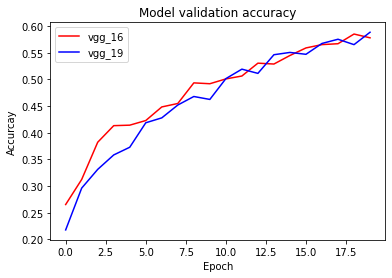

In [26]:
plt.plot(history_16.history['val_accuracy'],'r')
plt.plot(history_19.history['val_accuracy'],'b')
plt.title('Model validation accuracy')
plt.ylabel('Accurcay')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

#### VGG-16과 VGG-19의 비교 결과
* 두 모델의 학습 결과를 비교했을 때 정확도에서 많은 차이가 드러나진 않았다.
* 권장 학습 Epoch인 40 Epoch을 충족하지 않아 발생했다기에는 최종 결과를 제외하고는 VGG-16의 학습 결과가 전반적으로 좋은 모습을 보인다.
* 후에 학습할 ResNet과 Plain Net의 비교를 확인하는 것이 학습 결과의 차이를 확인하는데 더 적합할 것 같다.